In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pylab

from uplift.metrics import uplift_at_k,qini_auc_score
from uplift.ensemble import RandomForestClassifier
from uplift.vizualization import  plot_qini_curve

from sklearn.model_selection import ParameterGrid
from pprint import pprint

In [50]:
import numpy as np
import pandas as pd
from sklearn.metrics import auc
from sklearn.utils.extmath import stable_cumsum
from sklearn.utils.validation import check_consistent_length

def uplift_curve(y_true, uplift, treatment):
    """Compute Uplift curve.
    For computing the area under the Uplift Curve, see :func:`.uplift_auc_score`.
    Args:
        y_true (1d array-like): Correct (true) target values.
        uplift (1d array-like): Predicted uplift, as returned by a model.
        treatment (1d array-like): Treatment labels.
    Returns:
        array (shape = [>2]), array (shape = [>2]): Points on a curve.
    See also:
        :func:`.uplift_auc_score`: Compute normalized Area Under the Uplift curve from prediction scores.
        :func:`.perfect_uplift_curve`: Compute the perfect Uplift curve.
        :func:`.plot_uplift_curve`: Plot Uplift curves from predictions.
        :func:`.qini_curve`: Compute Qini curve.
    References:
        Devriendt, F., Guns, T., & Verbeke, W. (2020). Learning to rank for uplift modeling. ArXiv, abs/2002.05897.
    """

    check_consistent_length(y_true, uplift, treatment)
    
    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)

    desc_score_indices = np.argsort(uplift, kind="mergesort")[::-1]
    y_true, uplift, treatment = y_true[desc_score_indices], uplift[desc_score_indices], treatment[desc_score_indices]

    y_true_ctrl, y_true_trmnt = y_true.copy(), y_true.copy()

    y_true_ctrl[treatment == 1] = 0
    y_true_trmnt[treatment == 0] = 0

    distinct_value_indices = np.where(np.diff(uplift))[0]
    threshold_indices = np.r_[distinct_value_indices, uplift.size - 1]

    num_trmnt = stable_cumsum(treatment)[threshold_indices]
    y_trmnt = stable_cumsum(y_true_trmnt)[threshold_indices]

    num_all = threshold_indices + 1

    num_ctrl = num_all - num_trmnt
    y_ctrl = stable_cumsum(y_true_ctrl)[threshold_indices]

    curve_values = (np.divide(y_trmnt, num_trmnt, out=np.zeros_like(y_trmnt), where=num_trmnt != 0) -
                    np.divide(y_ctrl, num_ctrl, out=np.zeros_like(y_ctrl), where=num_ctrl != 0)) * num_all

    if num_all.size == 0 or curve_values[0] != 0 or num_all[0] != 0:
        # Add an extra threshold position if necessary
        # to make sure that the curve starts at (0, 0)
        num_all = np.r_[0, num_all]
        curve_values = np.r_[0, curve_values]

    return num_all, curve_values


def perfect_uplift_curve(y_true, treatment):
    """Compute the perfect (optimum) Uplift curve.
    This is a function, given points on a curve.  For computing the
    area under the Uplift Curve, see :func:`.uplift_auc_score`.
    Args:
        y_true (1d array-like): Correct (true) target values.
        treatment (1d array-like): Treatment labels.
    Returns:
        array (shape = [>2]), array (shape = [>2]): Points on a curve.
    See also:
        :func:`.uplift_curve`: Compute the area under the Qini curve.
        :func:`.uplift_auc_score`: Compute normalized Area Under the Uplift curve from prediction scores.
        :func:`.plot_uplift_curve`: Plot Uplift curves from predictions.
    """

    check_consistent_length(y_true, treatment)
    
    y_true, treatment = np.array(y_true), np.array(treatment)

    cr_num = np.sum((y_true == 1) & (treatment == 0))  # Control Responders
    tn_num = np.sum((y_true == 0) & (treatment == 1))  # Treated Non-Responders

    # express an ideal uplift curve through y_true and treatment
    summand = y_true if cr_num > tn_num else treatment
    perfect_uplift = 2 * (y_true == treatment) + summand

    return uplift_curve(y_true, perfect_uplift, treatment)


def uplift_auc_score(y_true, uplift, treatment):
    """Compute normalized Area Under the Uplift Curve from prediction scores.
    By computing the area under the Uplift curve, the curve information is summarized in one number.
    For binary outcomes the ratio of the actual uplift gains curve above the diagonal to that of
    the optimum Uplift Curve.
    Args:
        y_true (1d array-like): Correct (true) target values.
        uplift (1d array-like): Predicted uplift, as returned by a model.
        treatment (1d array-like): Treatment labels.
    Returns:
        float: Area Under the Uplift Curve.
    See also:
        :func:`.uplift_curve`: Compute Uplift curve.
        :func:`.perfect_uplift_curve`: Compute the perfect (optimum) Uplift curve.
        :func:`.plot_uplift_curve`: Plot Uplift curves from predictions.
        :func:`.qini_auc_score`: Compute normalized Area Under the Qini Curve from prediction scores.
    """

    check_consistent_length(y_true, uplift, treatment)
    
    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)

    x_actual, y_actual = uplift_curve(y_true, uplift, treatment)
    x_perfect, y_perfect = perfect_uplift_curve(y_true, treatment)
    x_baseline, y_baseline = np.array([0, x_perfect[-1]]), np.array([0, y_perfect[-1]])

    auc_score_baseline = auc(x_baseline, y_baseline)
    auc_score_perfect = auc(x_perfect, y_perfect) - auc_score_baseline
    auc_score_actual = auc(x_actual, y_actual) - auc_score_baseline

    return auc_score_actual / auc_score_perfect

In [10]:
# функция для уменьшения объёма датасета за счёт изменения типов
def reduce_mem_usage(df, verbose=True): 
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [21]:
#const
import pandas as pd
from sklearn.preprocessing import StandardScaler 

N_ROWS = 5000000 #number of samples

df_dataset = pd.read_csv("DATASETS/criteo-uplift.csv", nrows = N_ROWS)

df_dataset = reduce_mem_usage(df_dataset)


df_features = pd.DataFrame({
    'f0': df_dataset['f0'],
    'f1': df_dataset['f1'],
    'f2': df_dataset['f2'],
    'f3': df_dataset['f3'],
    'f4': df_dataset['f4'],
    'f5': df_dataset['f5'],
    'f6': df_dataset['f6'],
    'f7': df_dataset['f7'],
    'f8': df_dataset['f8'],
    'f9': df_dataset['f9'],
    'f10': df_dataset['f10'],
    'f11': df_dataset['f11'],
},index = df_dataset.index)
#fit on 
indices_all =  [i for i in range(df_dataset.shape[0])]

indices_train, indices_test = train_test_split(indices_all,test_size = 0.3)
indices_test, indices_eval = train_test_split(indices_test, test_size = 0.5)

X_train = df_features.loc[indices_train].values
treatment_train = df_dataset.loc[indices_train,'treatment'].values
Y_train_visit = df_dataset.loc[indices_train,'visit'].values

X_test = df_features.loc[indices_test].values
Y_test_visit =  df_dataset.loc[indices_test,'visit'].values
treatment_test = df_dataset.loc[indices_test,'treatment'].values

X_eval = df_features.loc[indices_eval].values
Y_eval_visit =  df_dataset.loc[indices_eval,'visit'].values
treatment_eval = df_dataset.loc[indices_eval,'treatment'].values


scaler = StandardScaler(with_std = True, with_mean = True)

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_eval = scaler.fit_transform(X_eval)


Mem. usage decreased to 133.51 Mb (78.1% reduction)


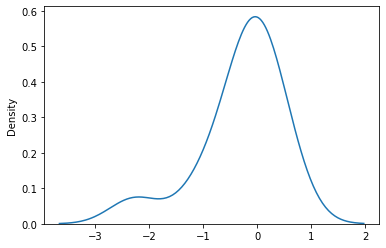

In [61]:
import seaborn as sns

sns.kdeplot(X_train[10000])

In [28]:
print("уровень воздействий в train:", treatment_train[treatment_train == 1].shape[0] / treatment_train.shape[0])
print("уровень воздействий в test:", treatment_test[treatment_test == 1].shape[0] / treatment_test.shape[0])
print("уровень воздействий в eval:", treatment_eval[treatment_eval == 1].shape[0] / treatment_eval.shape[0])

print("------------------------------------")

print("уровень целевых реакций (visit) в train:", Y_train_visit[Y_train_visit == 1].shape[0] / Y_train_visit.shape[0])
print("уровень целевых реакций (visit) в test:", Y_test_visit[Y_test_visit == 1].shape[0] / Y_test_visit.shape[0])
print("уровень целевых реакций (visit) в eval:", Y_eval_visit[Y_eval_visit == 1].shape[0] / Y_eval_visit.shape[0])

print("------------------------------------")

print("train")

print(X_train.shape)
print(Y_train_visit.shape)
print(treatment_train.shape)

print("eval")

print(X_eval.shape)
print(treatment_eval.shape)
print(Y_eval_visit.shape)

print("test")

print(X_test.shape)
print(treatment_test.shape)
print(Y_test_visit.shape)

уровень воздействий в train: 0.8460897142857143
уровень воздействий в test: 0.846056
уровень воздействий в eval: 0.8459093333333333
------------------------------------
уровень целевых реакций (visit) в train: 0.041324285714285716
уровень целевых реакций (visit) в test: 0.04133333333333333
уровень целевых реакций (visit) в eval: 0.041288
------------------------------------
train
(3500000, 12)
(3500000,)
(3500000,)
eval
(750000, 12)
(750000,)
(750000,)
test
(750000, 12)
(750000,)
(750000,)


# одна модель

In [110]:
import xgboost as xgb
from uplift.models import OneModel
eval_set =  [(np.column_stack((X_eval,treatment_eval)), Y_eval_visit)] 
clf = xgb.XGBClassifier(learning_rate = 0.045, max_depth=4, 
                                      n_estimators=1000,subsample = 0.75 , colsample_bytree= 1.0)  
sm = OneModel(clf)
sm = sm.fit(X_train, Y_train_visit, treatment_train, estimator_fit_params={'early_stopping_rounds': 10,
                                        'eval_metric':"auc", "eval_set":eval_set,'verbose':10})

[0]	validation_0-auc:0.90558
Will train until validation_0-auc hasn't improved in 10 rounds.
[10]	validation_0-auc:0.90801
[20]	validation_0-auc:0.90910
[30]	validation_0-auc:0.91115
[40]	validation_0-auc:0.91145
[50]	validation_0-auc:0.91145
[60]	validation_0-auc:0.91148
[70]	validation_0-auc:0.91155
[80]	validation_0-auc:0.91164
[90]	validation_0-auc:0.91167
[100]	validation_0-auc:0.91171
Stopping. Best iteration:
[95]	validation_0-auc:0.91172



In [109]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = df_features.loc[indices_valid_new, :]
    treatment_valid = df_dataset.loc[indices_valid_new, 'treatment'].values
    target_valid = df_dataset.loc[indices_valid_new, 'visit'].values
    
    X_valid = scaler.fit_transform(X_valid)

    valid_pred = sm.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.4700159919404217 with p_value =  0.09238008162314508
Kendal uplift rank correlation =  0.1807753815155468 with p_value =  0.5174392393363941
Kendal uplift rank correlation =  0.5423261445466404 with p_value =  0.052150014561058396
Kendal uplift rank correlation =  0.32539568672798425 with p_value =  0.2439639465303467
Kendal uplift rank correlation =  0.036155076303109365 with p_value =  0.8969940255412855
Kendal uplift rank correlation =  0.5423261445466404 with p_value =  0.052150014561058396
Kendal uplift rank correlation =  0.2530855341217655 with p_value =  0.36482106534871384
Kendal uplift rank correlation =  0.6146362971528592 with p_value =  0.027749304190886104
Kendal uplift rank correlation =  0.10846522890932808 with p_value =  0.6977358290647567
Kendal uplift rank correlation =  0.10846522890932808 with p_value =  0.6977358290647567
Kendal uplift rank correlation =  0.6146362971528592 with p_value =  0.027749304190886104
Kendal uplift ran

Kendal uplift rank correlation =  0.39770583933420295 with p_value =  0.15443051915129236
Kendal uplift rank correlation =  0.5423261445466404 with p_value =  0.052150014561058396
Kendal uplift rank correlation =  0.4700159919404217 with p_value =  0.09238008162314508
Kendal uplift rank correlation =  0.5423261445466404 with p_value =  0.052150014561058396
Kendal uplift rank correlation =  0.036155076303109365 with p_value =  0.8969940255412855
Kendal uplift rank correlation =  0.39770583933420295 with p_value =  0.15443051915129236
Kendal uplift rank correlation =  0.4700159919404217 with p_value =  0.09238008162314508
Kendal uplift rank correlation =  0.6146362971528592 with p_value =  0.027749304190886104
Число замеров 100
AUQC: mean:  185293153.6375141 | std:  17947246.0556571
uplift30%: mean:  0.0459572208047957 | std:  0.0020015992298041277
Kendall_rank_correlation: mean:  0.33407290504073045 | std:  0.19235538510024813
AUUC: mean:  0.02933339442918143 | std:  0.00289023068412183

In [51]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = df_features.loc[indices_valid_new, :]
    treatment_valid = df_dataset.loc[indices_valid_new, 'treatment'].values
    target_valid = df_dataset.loc[indices_valid_new, 'visit'].values
    
    X_valid = scaler.fit_transform(X_valid)

    valid_pred = sm.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.4472135954999579 with p_value =  0.1171850871981381
Kendal uplift rank correlation =  0.4472135954999579 with p_value =  0.1171850871981381
Kendal uplift rank correlation =  0.4472135954999579 with p_value =  0.1171850871981381
Kendal uplift rank correlation =  0.4472135954999579 with p_value =  0.1171850871981381
Kendal uplift rank correlation =  0.4472135954999579 with p_value =  0.1171850871981381
Kendal uplift rank correlation =  0.4472135954999579 with p_value =  0.1171850871981381
Kendal uplift rank correlation =  0.4472135954999579 with p_value =  0.1171850871981381
Kendal uplift rank correlation =  0.4472135954999579 with p_value =  0.1171850871981381
Kendal uplift rank correlation =  0.4472135954999579 with p_value =  0.1171850871981381
Kendal uplift rank correlation =  0.4472135954999579 with p_value =  0.1171850871981381
Kendal uplift rank correlation =  0.4472135954999579 with p_value =  0.1171850871981381
Kendal uplift rank correlation =

Kendal uplift rank correlation =  0.4472135954999579 with p_value =  0.1171850871981381
Kendal uplift rank correlation =  0.4472135954999579 with p_value =  0.1171850871981381
Kendal uplift rank correlation =  0.4472135954999579 with p_value =  0.1171850871981381
Kendal uplift rank correlation =  0.4472135954999579 with p_value =  0.1171850871981381
Kendal uplift rank correlation =  0.4472135954999579 with p_value =  0.1171850871981381
Kendal uplift rank correlation =  0.4472135954999579 with p_value =  0.1171850871981381
Число замеров 100
AUQC: mean:  45121244.273229524 | std:  6419240.50865148
uplift30%: mean:  0.02191321978896531 | std:  0.0014713288558546945
Kendall_rank_correlation: mean:  0.4472135954999581 | std:  1.6737241846796128e-16
AUUC: mean:  0.0075314100889121134 | std:  0.001069001582691906


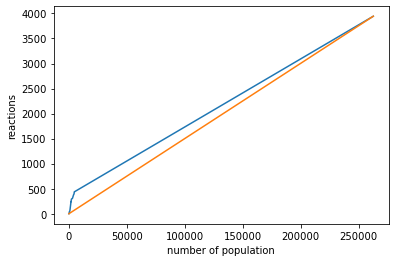

In [56]:
from uplift.metrics import qini_curve
import matplotlib.pyplot as plt

x,y = qini_curve(target_valid, valid_pred, treatment_valid)
plt.plot(x, y)
plt.xlabel('number of population')
plt.ylabel('reactions')
plt.plot([ x[0], x[len(x)-1] ], [ y[0], y[len(y) - 1  ]] )

# Трансформация классов

In [69]:
from uplift.models import ClassTransformation
eval_set =  [(X_eval, Y_eval_visit)] 

clf = xgb.XGBClassifier(learning_rate=0.001, max_depth=4, 
                                      n_estimators=10000,min_split_gain = 0,subsample = 0.5 ,colsample_bytree = 0.6)  
ct =  ClassTransformation(clf)
ct = ct.fit(X_train, Y_train_visit, treatment_train, estimator_fit_params={'early_stopping_rounds': 10,
                                        'eval_metric':"auc", "eval_set":eval_set})

[0]	validation_0-auc:0.80404
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.83672
[2]	validation_0-auc:0.83697
[3]	validation_0-auc:0.83754
[4]	validation_0-auc:0.84397
[5]	validation_0-auc:0.84679
[6]	validation_0-auc:0.84530
[7]	validation_0-auc:0.84346
[8]	validation_0-auc:0.83974
[9]	validation_0-auc:0.84288
[10]	validation_0-auc:0.84357
[11]	validation_0-auc:0.84106
[12]	validation_0-auc:0.84121
[13]	validation_0-auc:0.84850
[14]	validation_0-auc:0.85015
[15]	validation_0-auc:0.85004
[16]	validation_0-auc:0.84994
[17]	validation_0-auc:0.85050
[18]	validation_0-auc:0.85010
[19]	validation_0-auc:0.84929
[20]	validation_0-auc:0.84828
[21]	validation_0-auc:0.84620
[22]	validation_0-auc:0.84619
[23]	validation_0-auc:0.84741
[24]	validation_0-auc:0.84958
[25]	validation_0-auc:0.84950
[26]	validation_0-auc:0.84985
[27]	validation_0-auc:0.85005
Stopping. Best iteration:
[17]	validation_0-auc:0.85050



In [70]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = df_features.loc[indices_valid_new, :]
    treatment_valid = df_dataset.loc[indices_valid_new, 'treatment'].values
    target_valid = df_dataset.loc[indices_valid_new, 'visit'].values
    
    X_valid = scaler.fit_transform(X_valid)

    valid_pred = ct.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.6741998624632421 with p_value =  0.007058332048528094
Kendal uplift rank correlation =  0.5843065474681431 with p_value =  0.019550269092885545
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.7191465199607916 with p_value =  0.004057136032371292
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.6741998624632421 with p_value =  0.007058332048528094
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.67419986

Kendal uplift rank correlation =  0.7191465199607916 with p_value =  0.004057136032371292
Kendal uplift rank correlation =  0.5843065474681431 with p_value =  0.019550269092885545
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.7191465199607916 with p_value =  0.004057136032371292
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Число замеров 100
AUQC: mean:  449764163.15341026 | std:  15217496.913497195
uplift30%: mean:  0.05244260197465829 | std:  0.002084566318065489
Kendall_rank_correlation: mean:  0.5970735438850029 | std:  0.09203281186268339
AUUC: mean:  0.07809018767691643 | std:  0.002729677640151169


# Две независимые модели

In [72]:
from uplift.models import TwoModels
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

eval_set =  [(X_eval, Y_eval_visit)] 
clf_lgbm = LGBMClassifier(
    boosting_type='gbdt',
    n_estimators=1000,
    max_depth=2,
    learning_rate=0.5,
    random_state=RANDOM_STATE,
    
)

xgb_clf = XGBClassifier(max_depth =2,
            learning_rate= 0.2,
            n_estimators = 1000,
            nthread =40,
            n_gpus =0,
            seed = 42)

model_two = TwoModels(estimator_trmnt = clf_lgbm, estimator_ctrl = xgb_clf, method = 'two_independent')

clf = model_two.fit(X_train, Y_train_visit, treatment_train, estimator_trmnt_fit_params={'early_stopping_rounds': 10,
                                        'eval_metric':"auc", "eval_set":eval_set}, 
                    estimator_ctrl_fit_params={'early_stopping_rounds': 10,
                                        'eval_metric':"auc", "eval_set":eval_set})


[0]	validation_0-auc:0.85274
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.87629
[2]	validation_0-auc:0.88019
[3]	validation_0-auc:0.88617
[4]	validation_0-auc:0.89322
[5]	validation_0-auc:0.89403
[6]	validation_0-auc:0.89426
[7]	validation_0-auc:0.89458
[8]	validation_0-auc:0.89484
[9]	validation_0-auc:0.91002
[10]	validation_0-auc:0.91135
[11]	validation_0-auc:0.91201
[12]	validation_0-auc:0.91166
[13]	validation_0-auc:0.91172
[14]	validation_0-auc:0.91093
[15]	validation_0-auc:0.91275
[16]	validation_0-auc:0.91302
[17]	validation_0-auc:0.91155
[18]	validation_0-auc:0.91259
[19]	validation_0-auc:0.91296
[20]	validation_0-auc:0.91247
[21]	validation_0-auc:0.91246
[22]	validation_0-auc:0.91322
[23]	validation_0-auc:0.91326
[24]	validation_0-auc:0.91334
[25]	validation_0-auc:0.91365
[26]	validation_0-auc:0.91354
[27]	validation_0-auc:0.91390
[28]	validation_0-auc:0.91506
[29]	validation_0-auc:0.91516
[30]	validation_0-auc:0.91542
[31]	validation_

[63]	valid_0's auc: 0.924256	valid_0's binary_logloss: 0.100985
[64]	valid_0's auc: 0.924322	valid_0's binary_logloss: 0.100939
[65]	valid_0's auc: 0.924241	valid_0's binary_logloss: 0.100931
[66]	valid_0's auc: 0.924259	valid_0's binary_logloss: 0.100924
[67]	valid_0's auc: 0.924384	valid_0's binary_logloss: 0.100909
[68]	valid_0's auc: 0.924399	valid_0's binary_logloss: 0.100894
[69]	valid_0's auc: 0.9244	valid_0's binary_logloss: 0.100881
[70]	valid_0's auc: 0.924382	valid_0's binary_logloss: 0.100859
[71]	valid_0's auc: 0.924428	valid_0's binary_logloss: 0.100807
[72]	valid_0's auc: 0.924435	valid_0's binary_logloss: 0.100801
[73]	valid_0's auc: 0.924626	valid_0's binary_logloss: 0.100786
[74]	valid_0's auc: 0.924574	valid_0's binary_logloss: 0.100787
[75]	valid_0's auc: 0.92452	valid_0's binary_logloss: 0.100771
[76]	valid_0's auc: 0.924527	valid_0's binary_logloss: 0.100757
[77]	valid_0's auc: 0.924476	valid_0's binary_logloss: 0.100729
[78]	valid_0's auc: 0.924612	valid_0's bina

[190]	valid_0's auc: 0.925731	valid_0's binary_logloss: 0.100123
[191]	valid_0's auc: 0.925738	valid_0's binary_logloss: 0.100116
[192]	valid_0's auc: 0.925752	valid_0's binary_logloss: 0.100111
[193]	valid_0's auc: 0.925761	valid_0's binary_logloss: 0.100106
[194]	valid_0's auc: 0.92575	valid_0's binary_logloss: 0.100104
[195]	valid_0's auc: 0.925768	valid_0's binary_logloss: 0.100101
[196]	valid_0's auc: 0.925769	valid_0's binary_logloss: 0.1001
[197]	valid_0's auc: 0.925771	valid_0's binary_logloss: 0.100096
[198]	valid_0's auc: 0.925775	valid_0's binary_logloss: 0.100095
[199]	valid_0's auc: 0.92578	valid_0's binary_logloss: 0.100092
[200]	valid_0's auc: 0.925782	valid_0's binary_logloss: 0.10009
[201]	valid_0's auc: 0.925783	valid_0's binary_logloss: 0.100092
[202]	valid_0's auc: 0.925798	valid_0's binary_logloss: 0.100088
[203]	valid_0's auc: 0.925796	valid_0's binary_logloss: 0.10009
[204]	valid_0's auc: 0.925796	valid_0's binary_logloss: 0.10009
[205]	valid_0's auc: 0.925784	va

In [73]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = df_features.loc[indices_valid_new, :]
    treatment_valid = df_dataset.loc[indices_valid_new, 'treatment'].values
    target_valid = df_dataset.loc[indices_valid_new, 'visit'].values
    
    X_valid = scaler.fit_transform(X_valid)

    valid_pred = model_two.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.764093177458341 with p_value =  0.002263469812035179
Kendal uplift rank correlation =  0.6741998624632421 with p_value =  0.007058332048528094
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.4944132324730442 with p_value =  0.04819348829319082
Kendal uplift rank correlation =  0.4944132324730442 with p_value =  0.04819348829319082
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.764093177458341 with p_value =  0.002263469812035179
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation = 

Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.3595732599803958 with p_value =  0.15076277502664528
Kendal uplift rank correlation =  0.6741998624632421 with p_value =  0.007058332048528094
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.764093177458341 with p_value =  0.002263469812035179
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Число замеров 100
AUQC: mean:  338435646.08741057 | std:  43540083.82358872
uplift30%: mean:  0.051216717889933164 | std:  0.002055660389687462
Kendall_rank_correlation: mean:  0.5453623022829847 | std:  0.18272731829846578
AUUC: mean:  0.05761563596043749 | std:  0.007955598619312332


# Две зависимые модели Т, С

In [76]:
from uplift.models import TwoModels
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

eval_set =  [(X_eval, Y_eval_visit)] 
clf_lgbm = LGBMClassifier(
    boosting_type='gbdt',
    n_estimators=1000,
    max_depth=2,
    learning_rate=0.5,
    random_state=RANDOM_STATE,
    
)

xgb_clf = XGBClassifier(max_depth =2,
            learning_rate= 0.2,
            n_estimators = 200,
            nthread =40,
            n_gpus =0,
            seed = 42)

model_two_T = TwoModels(estimator_trmnt = clf_lgbm, estimator_ctrl = xgb_clf, method = 'two_dependent_treatment')

clf = model_two_T.fit(X_train, Y_train_visit, treatment_train, estimator_trmnt_fit_params={'early_stopping_rounds': 10,
                                        'eval_metric':"auc", "eval_set":eval_set})


[1]	valid_0's auc: 0.851689	valid_0's binary_logloss: 0.144428
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.875271	valid_0's binary_logloss: 0.116109
[3]	valid_0's auc: 0.906847	valid_0's binary_logloss: 0.110888
[4]	valid_0's auc: 0.910542	valid_0's binary_logloss: 0.108283
[5]	valid_0's auc: 0.911649	valid_0's binary_logloss: 0.107009
[6]	valid_0's auc: 0.91605	valid_0's binary_logloss: 0.106332
[7]	valid_0's auc: 0.916497	valid_0's binary_logloss: 0.105964
[8]	valid_0's auc: 0.917156	valid_0's binary_logloss: 0.105292
[9]	valid_0's auc: 0.91761	valid_0's binary_logloss: 0.105104
[10]	valid_0's auc: 0.91749	valid_0's binary_logloss: 0.104692
[11]	valid_0's auc: 0.919034	valid_0's binary_logloss: 0.104386
[12]	valid_0's auc: 0.919406	valid_0's binary_logloss: 0.104
[13]	valid_0's auc: 0.919258	valid_0's binary_logloss: 0.103758
[14]	valid_0's auc: 0.919477	valid_0's binary_logloss: 0.103595
[15]	valid_0's auc: 0.91965	valid_0's binary_logloss: 0.10

[130]	valid_0's auc: 0.925227	valid_0's binary_logloss: 0.100362
[131]	valid_0's auc: 0.925288	valid_0's binary_logloss: 0.100359
[132]	valid_0's auc: 0.925307	valid_0's binary_logloss: 0.100344
[133]	valid_0's auc: 0.925325	valid_0's binary_logloss: 0.100343
[134]	valid_0's auc: 0.925324	valid_0's binary_logloss: 0.100338
[135]	valid_0's auc: 0.92533	valid_0's binary_logloss: 0.100332
[136]	valid_0's auc: 0.925348	valid_0's binary_logloss: 0.100312
[137]	valid_0's auc: 0.925372	valid_0's binary_logloss: 0.100303
[138]	valid_0's auc: 0.925385	valid_0's binary_logloss: 0.100301
[139]	valid_0's auc: 0.925388	valid_0's binary_logloss: 0.100299
[140]	valid_0's auc: 0.92541	valid_0's binary_logloss: 0.10029
[141]	valid_0's auc: 0.92541	valid_0's binary_logloss: 0.100291
[142]	valid_0's auc: 0.925442	valid_0's binary_logloss: 0.100284
[143]	valid_0's auc: 0.92543	valid_0's binary_logloss: 0.100278
[144]	valid_0's auc: 0.925393	valid_0's binary_logloss: 0.100264
[145]	valid_0's auc: 0.925407	

In [77]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = df_features.loc[indices_valid_new, :]
    treatment_valid = df_dataset.loc[indices_valid_new, 'treatment'].values
    target_valid = df_dataset.loc[indices_valid_new, 'visit'].values
    
    X_valid = scaler.fit_transform(X_valid)

    valid_pred = model_two_T.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.9555555555555554 with p_value =  5.5114638447971785e-06
Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Kendal uplift rank correlation =  0.9555555555555554 with p_value =  5.5114638447971785e-0

Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Kendal uplift rank correlation =  0.9555555555555554 with p_value =  5.5114638447971785e-06
Kendal uplift rank correlation =  0.9555555555555554 with p_value =  5.5114638447971785e-06
Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Число замеров 100
AUQC: mean:  337399639.5148479 | std:  35236587.86709779
uplift30%: mean:  0.05182643385924608 | std:  0.0022264032965276037
Kendall_rank_correlation: mean:  0.79274

# Две зависимые модели C, T

In [92]:
from uplift.models import TwoModels
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

eval_set =  [(X_eval, Y_eval_visit)] 
clf_lgbm = LGBMClassifier(
    boosting_type='gbdt',
    n_estimators=300,
    max_depth=4,
    learning_rate=0.5,
    random_state=RANDOM_STATE,
    
)

xgb_clf = XGBClassifier(max_depth =4,
            learning_rate= 0.2,
            n_estimators = 1000,
            nthread =40,
            n_gpus =0,
            seed = 42)

model_two_C = TwoModels(estimator_trmnt = clf_lgbm, estimator_ctrl = xgb_clf, method = 'two_dependent_control')

clf = model_two_C.fit(X_train, Y_train_visit, treatment_train, estimator_ctrl_fit_params={'early_stopping_rounds': 10,
                                        'eval_metric':"auc", "eval_set":eval_set})


[0]	validation_0-auc:0.90294
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.90697
[2]	validation_0-auc:0.90747
[3]	validation_0-auc:0.90795
[4]	validation_0-auc:0.91319
[5]	validation_0-auc:0.91466
[6]	validation_0-auc:0.91606
[7]	validation_0-auc:0.91626
[8]	validation_0-auc:0.91724
[9]	validation_0-auc:0.91730
[10]	validation_0-auc:0.91759
[11]	validation_0-auc:0.91914
[12]	validation_0-auc:0.91928
[13]	validation_0-auc:0.91936
[14]	validation_0-auc:0.91983
[15]	validation_0-auc:0.92017
[16]	validation_0-auc:0.92019
[17]	validation_0-auc:0.92030
[18]	validation_0-auc:0.92071
[19]	validation_0-auc:0.92081
[20]	validation_0-auc:0.92109
[21]	validation_0-auc:0.92106
[22]	validation_0-auc:0.92119
[23]	validation_0-auc:0.92148
[24]	validation_0-auc:0.92167
[25]	validation_0-auc:0.92171
[26]	validation_0-auc:0.92187
[27]	validation_0-auc:0.92186
[28]	validation_0-auc:0.92194
[29]	validation_0-auc:0.92190
[30]	validation_0-auc:0.92189
[31]	validation_

In [93]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = df_features.loc[indices_valid_new, :]
    treatment_valid = df_dataset.loc[indices_valid_new, 'treatment'].values
    target_valid = df_dataset.loc[indices_valid_new, 'visit'].values
    
    X_valid = scaler.fit_transform(X_valid)

    valid_pred = model_two_C.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.40451991747794525 with p_value =  0.10599754842494577
Kendal uplift rank correlation =  0.5393598899705937 with p_value =  0.031141210595796737
Kendal uplift rank correlation =  0.44946657497549475 with p_value =  0.0724860850868465
Kendal uplift rank correlation =  0.44946657497549475 with p_value =  0.0724860850868465
Kendal uplift rank correlation =  0.44946657497549475 with p_value =  0.0724860850868465
Kendal uplift rank correlation =  0.5393598899705937 with p_value =  0.031141210595796737
Kendal uplift rank correlation =  0.5843065474681431 with p_value =  0.019550269092885545
Kendal uplift rank correlation =  0.5393598899705937 with p_value =  0.031141210595796737
Kendal uplift rank correlation =  0.5393598899705937 with p_value =  0.031141210595796737
Kendal uplift rank correlation =  0.4944132324730442 with p_value =  0.04819348829319082
Kendal uplift rank correlation =  0.4944132324730442 with p_value =  0.04819348829319082
Kendal uplift r

Kendal uplift rank correlation =  0.5393598899705937 with p_value =  0.031141210595796737
Kendal uplift rank correlation =  0.40451991747794525 with p_value =  0.10599754842494577
Kendal uplift rank correlation =  0.4944132324730442 with p_value =  0.04819348829319082
Kendal uplift rank correlation =  0.4944132324730442 with p_value =  0.04819348829319082
Kendal uplift rank correlation =  0.5393598899705937 with p_value =  0.031141210595796737
Kendal uplift rank correlation =  0.5843065474681431 with p_value =  0.019550269092885545
Kendal uplift rank correlation =  0.5843065474681431 with p_value =  0.019550269092885545
Kendal uplift rank correlation =  0.4944132324730442 with p_value =  0.04819348829319082
Число замеров 100
AUQC: mean:  142453974.9994241 | std:  17705874.105015013
uplift30%: mean:  0.03712603254117788 | std:  0.0016783947635272405
Kendall_rank_correlation: mean:  0.5034025639725541 | std:  0.06291883435312094
AUUC: mean:  0.02543223442113175 | std:  0.0029833228516345

# Uplift деревья

In [94]:
from uplift.ensemble import RandomForestClassifier

up_rf =  RandomForestClassifier(n_estimators = 150, min_samples_leaf = 10000, 
                                    max_features =0.5,
                                criterion='uplift_gini',n_jobs=-1,bootstrap=True)
    
up_rf = up_rf.fit(X_train, Y_train_visit, treatment_train)

In [95]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = df_features.loc[indices_valid_new, :]
    treatment_valid = df_dataset.loc[indices_valid_new, 'treatment'].values
    target_valid = df_dataset.loc[indices_valid_new, 'visit'].values
    
    X_valid = scaler.fit_transform(X_valid)

    valid_pred = up_rf.predict_uplift(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.9555555555555554 with p_value =  5.5114638447971785e-06
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.9555555555555554 with p_value =  5.5114638447971785e-06
Kendal uplift rank correlation =  0.764093177458341 with p_value =  0.002263469812035179
Kendal uplift rank correlation =  0.9555555555555554 with p_value =  5.5114638447971785e-06
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.6741998624632421 with p_value =  0.007058332048528094
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.6741998624632421 with p_value =  0.007058332048528094
Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102


Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.8090398349558905 with p_value =  0.0012254240706707125
Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.6741998624632421 with p_value =  0.007058332048528094
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.9555555555555554 with p_value =  5.5114638447971785e-06
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.764093177458341 with p_value =  0.002263469812035179
Число замеров 100
AUQC: mean:  434666208.0605223 | std:  29597070.06257661
uplift30%: mea

# uplift деревья со стат тестом

In [104]:
from uplift.ensemble import RandomForestClassifier

up_rf_stat =  RandomForestClassifier(n_estimators = 150, min_samples_leaf = 10000, 
                                    max_features =0.5,
                                criterion='stat_test', n_jobs=-1,bootstrap=True,stat_param=40)
    
up_rf_stat = up_rf_stat.fit(X_train, Y_train_visit, treatment_train)

In [105]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = df_features.loc[indices_valid_new, :]
    treatment_valid = df_dataset.loc[indices_valid_new, 'treatment'].values
    target_valid = df_dataset.loc[indices_valid_new, 'visit'].values
    
    X_valid = scaler.fit_transform(X_valid)

    valid_pred = up_rf_stat.predict_uplift(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.6292532049656925 with p_value =  0.01192100149691403
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.6292532049656925 with p_value =  0.01192100149691403
Kendal uplift rank correlation =  0.8539864924534399 with p_value =  0.0006436975254696877
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.6292532049656925 with p_value =  0.01192100149691403
Kendal uplift rank correlation =  0.9555555555555554 with p_value =  5.5114638447971785e-06
Kendal uplift rank correlation =  0.5843065474681431 with p_value =  0.019550269092885545
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kenda

Kendal uplift rank correlation =  0.6741998624632421 with p_value =  0.007058332048528094
Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Kendal uplift rank correlation =  0.764093177458341 with p_value =  0.002263469812035179
Kendal uplift rank correlation =  0.6741998624632421 with p_value =  0.007058332048528094
Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.9555555555555554 with p_value =  5.5114638447971785e-06
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Число замеров 100
AUQC: mean:  408222781.873791 | std:  15877968.582689784
uplift30%: mean:  0.05664986754303578 | std:  0.002030162057741937
Kendall_rank_correlation: mean:  0.817216632

# Трансформация классов (регрессия)

In [113]:
#const
import pandas as pd
from sklearn.preprocessing import StandardScaler 

N_ROWS = 5000000 #number of samples

df_dataset = pd.read_csv("DATASETS/criteo-uplift.csv", nrows = N_ROWS)

df_dataset = reduce_mem_usage(df_dataset)


df_features = pd.DataFrame({
    'f0': df_dataset['f0'],
    'f1': df_dataset['f1'],
    'f2': df_dataset['f2'],
    'f3': df_dataset['f3'],
    'f4': df_dataset['f4'],
    'f5': df_dataset['f5'],
    'f6': df_dataset['f6'],
    'f7': df_dataset['f7'],
    'f8': df_dataset['f8'],
    'f9': df_dataset['f9'],
    'f10': df_dataset['f10'],
    'f11': df_dataset['f11'],
},index = df_dataset.index)
#fit on 
indices_all =  [i for i in range(df_dataset.shape[0])]

p = 0.8462388

df_dataset['Z_trans'] = df_dataset['visit']* ( (df_dataset['treatment'] - p) / ( p*(1-p) ) )



indices_train, indices_test = train_test_split(indices_all,test_size = 0.3)
indices_test, indices_eval = train_test_split(indices_test, test_size = 0.5)

X_train = df_features.loc[indices_train].values
treatment_train = df_dataset.loc[indices_train,'treatment'].values
Y_train_visit = df_dataset.loc[indices_train,'visit'].values

X_test = df_features.loc[indices_test].values
Y_test_visit =  df_dataset.loc[indices_test,'visit'].values
treatment_test = df_dataset.loc[indices_test,'treatment'].values

X_eval = df_features.loc[indices_eval].values
Y_eval_visit =  df_dataset.loc[indices_eval,'visit'].values
treatment_eval = df_dataset.loc[indices_eval,'treatment'].values


scaler = StandardScaler(with_std = True, with_mean = True)

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_eval = scaler.fit_transform(X_eval)


all = df_dataset.copy()
train =all.loc[indices_train,]
test = all.loc[indices_test,]
eval = all.loc[indices_eval,]


Z_trans_train = train['Z_trans']
Z_trans_train = Z_trans_train.to_numpy()

Z_trans_test = test['Z_trans']
Z_trans_test = Z_trans_test.to_numpy()

Z_trans_eval = eval['Z_trans']


Mem. usage decreased to 133.51 Mb (78.1% reduction)


In [119]:
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

clf_reg = LGBMRegressor(
        boosting_type='gbdt',
        n_estimators=10000,
        max_depth=3,
        learning_rate=0.01,
        objective='regression',
        metric = 'mse'
)


clf_reg.fit(X_train, Z_trans_train, eval_set=[(X_eval, Z_trans_eval)],
        eval_metric='mse',
        early_stopping_rounds=25,verbose = 100)



y_pred = clf_reg.predict(X_eval, num_iteration = clf.best_iteration_)


print('MSE на тесте: ', mean_squared_error(Z_trans_eval, y_pred) )


# print('Feature importances:', list(clf.feature_importances_))

# plt.plot(list(clf.feature_importances_))

print("AUQC: ", qini_auc_score(Y_eval_visit, y_pred, treatment_eval))

print("uplift_30%: ",uplift_at_k(Y_eval_visit, y_pred, treatment_eval))

Training until validation scores don't improve for 25 rounds
[100]	valid_0's l2: 0.216666
[200]	valid_0's l2: 0.21596
[300]	valid_0's l2: 0.215696
[400]	valid_0's l2: 0.215572
[500]	valid_0's l2: 0.215511
[600]	valid_0's l2: 0.215487
[700]	valid_0's l2: 0.215459
[800]	valid_0's l2: 0.21545
Early stopping, best iteration is:
[827]	valid_0's l2: 0.215448
MSE на тесте:  0.21544819573247304
AUQC:  2948326985.5906906
uplift_30%:  0.05957300552349874


In [121]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = df_features.loc[indices_valid_new, :]
    treatment_valid = df_dataset.loc[indices_valid_new, 'treatment'].values
    target_valid = df_dataset.loc[indices_valid_new, 'visit'].values
    
    X_valid = scaler.fit_transform(X_valid)

    valid_pred = clf_reg.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.8740830418336487 with p_value =  0.000561008376035732
Kendal uplift rank correlation =  0.7360699299651778 with p_value =  0.0036714498212758124
Kendal uplift rank correlation =  0.9200874124564723 with p_value =  0.0002819259078333656
Kendal uplift rank correlation =  0.8539864924534399 with p_value =  0.0006436975254696877
Kendal uplift rank correlation =  0.7360699299651778 with p_value =  0.0036714498212758124
Kendal uplift rank correlation =  0.7820743005880014 with p_value =  0.002024186938238226
Kendal uplift rank correlation =  0.8740830418336487 with p_value =  0.000561008376035732
Kendal uplift rank correlation =  0.8539864924534399 with p_value =  0.0006436975254696877
Kendal uplift rank correlation =  0.8989331499509895 with p_value =  0.0003280163150135285
Kendal uplift rank correlation =  0.828078671210825 with p_value =  0.001082228864258376
Kendal uplift rank correlation =  0.828078671210825 with p_value =  0.001082228864258376
Kendal

Kendal uplift rank correlation =  0.7360699299651778 with p_value =  0.0036714498212758124
Kendal uplift rank correlation =  0.8539864924534399 with p_value =  0.0006436975254696877
Kendal uplift rank correlation =  0.9200874124564723 with p_value =  0.0002819259078333656
Kendal uplift rank correlation =  0.8740830418336487 with p_value =  0.000561008376035732
Kendal uplift rank correlation =  0.8989331499509895 with p_value =  0.0003280163150135285
Kendal uplift rank correlation =  0.828078671210825 with p_value =  0.001082228864258376
Kendal uplift rank correlation =  0.764093177458341 with p_value =  0.002263469812035179
Kendal uplift rank correlation =  0.764093177458341 with p_value =  0.002263469812035179
Kendal uplift rank correlation =  0.6292532049656925 with p_value =  0.01192100149691403
Число замеров 100
AUQC: mean:  355151054.2858299 | std:  20980782.24708481
uplift30%: mean:  0.05880106983713891 | std:  0.0022489920843996977
Kendall_rank_correlation: mean:  0.794832595784